#**LOAD BTC DATASET**

In [473]:
#from google.colab import files
#uploaded = files.upload()

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [474]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/BTC-USD.csv', index_col = 0, parse_dates = True, na_values = 0).dropna()

from datetime import timedelta

data =  data.loc['2017-11-29':]

data = data[:-90] # To cut the data and try earlier test timeframes


In [475]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-29,10077.400391,11517.400391,9601.030273,9888.610352,9888.610352,1.156880e+10
2017-11-30,9906.790039,10801.000000,9202.049805,10233.599609,10233.599609,8.310690e+09
2017-12-01,10198.599609,11046.700195,9694.650391,10975.599609,10975.599609,6.783120e+09
2017-12-02,10978.299805,11320.200195,10905.099609,11074.599609,11074.599609,5.138500e+09
2017-12-03,11082.700195,11858.700195,10862.000000,11323.200195,11323.200195,6.608310e+09


# **CREATE NEW FEATURES**

In [476]:
'''
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib
'''

'\n!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz\n!tar -xzvf ta-lib-0.4.0-src.tar.gz\n%cd ta-lib\n!./configure --prefix=/usr\n!make\n!make install\n!pip install Ta-Lib\n'

In [477]:
import talib as ta
data["EMA5"] = ta.EMA(data['Close'], timeperiod = 5)

data['DI5'] = (data['Close'] - data['EMA5']) / data['EMA5'] * 100

data["LowK"], data["SlowD"] = ta.STOCH(data["High"], data["Low"], data["Close"], fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)

data["MOM"] = ta.MOM(data['Close'], timeperiod=10)

data["ROC"] = ta.ROC(data['Close'], timeperiod=10)

data["WILLR"] = ta.WILLR(data["High"], data["Low"], data["Close"], timeperiod=14)

data["ADOSC"] = ta.ADOSC(data["High"], data["Low"], data["Close"], data["Volume"], fastperiod=3, slowperiod=10)

data.dropna(inplace=True)
data.head()

,Open,High,Low,Close,Adj Close,Volume,EMA5,DI5,LowK,SlowD,MOM,ROC,WILLR,ADOSC
Date,,,,,,,,,,,,,,
2017-12-12,16919.800781,17781.800781,16571.599609,17415.400391,17415.400391,1.460380e+10,16314.980992,6.744840,69.667582,63.622333,6340.800782,57.255350,-10.249853,1.882038e+10
2017-12-13,17500.000000,17653.099609,16039.700195,16408.199219,16408.199219,1.297690e+10,16346.053734,0.380186,74.639385,68.130144,5084.999024,44.907791,-21.255892,1.502434e+10
2017-12-14,16384.599609,17085.800781,16185.900391,16564.000000,16564.000000,1.377740e+10,16418.702489,0.884951,74.938374,73.081780,4906.799805,42.092438,-20.665805,1.140555e+10
2017-12-15,16601.300781,18154.099609,16601.300781,17706.900391,17706.900391,1.431000e+10,16848.101790,5.097302,75.615067,75.064275,5790.200196,48.588956,-8.629895,1.081885e+10
2017-12-16,17760.300781,19716.699219,17515.300781,19497.400391,19497.400391,1.274060e+10,17731.201324,9.960967,83.678569,78.077337,5205.900391,36.426550,-2.476638,1.284147e+10


In [478]:
# Create ternary labels (0 -> short, 1 -> sideways, 2 -> long)

min_profit = 0.01

close = np.array(data.Close)
future_close = np.array(data.shift(-1).Close)
y_labels = np.ones(len(data.Close))

for i in range(len(data.Close)):
  if future_close[i] > (1 + min_profit) * close[i]:
    y_labels[i] = 2  # buy
  elif future_close[i] < (1 - min_profit) * close[i]:
    y_labels[i] = 0  # sell
  else:
    y_labels[i] = 1  # side

from keras.utils.np_utils import to_categorical
y = to_categorical(y_labels, num_classes=3)

# Just checking labels make sense
print(y_labels[:5])
for i in range(5): print(y[i])

[0. 1. 2. 2. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 0. 1.]
[0. 0. 1.]
[1. 0. 0.]


In [479]:
np.ones((len(data.Close),3))[2]

array([1., 1., 1.])

#**DATA SCALING**



In [480]:
max_=data[['Open','High','Low','Close']].max().max()
min_=data[['Open','High','Low','Close']].min().min()

scl=MinMaxScaler()

X1=(data[['Open','High','Low','Close']]-min_)/(max_-min_)
X2=scl.fit_transform(data[['Volume']].values.reshape(-1,1))

X3 = scl.fit_transform(data[['EMA5']].values.reshape(-1,1))
X4 = scl.fit_transform(data[['DI5']].values.reshape(-1,1))

X5 = scl.fit_transform(data[['LowK']].values.reshape(-1,1))
X6 = scl.fit_transform(data[['SlowD']].values.reshape(-1,1))
X7 = scl.fit_transform(data[['MOM']].values.reshape(-1,1))

X8 = scl.fit_transform(data[['ROC']].values.reshape(-1,1))

X9 = scl.fit_transform(data[['WILLR']].values.reshape(-1,1))

X10 = scl.fit_transform(data[['ADOSC']].values.reshape(-1,1))

X1=np.array(X1)

data=data.assign(Open=X1[:,0])
data=data.assign(High=X1[:,1])
data=data.assign(Low=X1[:,2])
data=data.assign(Close=X1[:,3])
data=data.assign(Volume=X2[:,0])
data=data.assign(EMA5=X3)
data=data.assign(DI5=X4)
data=data.assign(LowK=X5)
data=data.assign(SlowD=X6)
data=data.assign(MOM=X7)
data=data.assign(ROC=X8)
data=data.assign(WILLR=X9)
data=data.assign(ADOSC=X10)
data.head(60)

,Open,High,Low,Close,Adj Close,Volume,EMA5,DI5,LowK,SlowD,MOM,ROC,WILLR,ADOSC
Date,,,,,,,,,,,,,,
2017-12-12,0.812448,0.863461,0.791841,0.841777,17415.400391,0.163971,0.855896,0.874126,0.705034,0.642626,1.000000,1.000000,0.897501,0.683551
2017-12-13,0.846784,0.855844,0.760364,0.782171,16408.199219,0.141131,0.857940,0.721898,0.758106,0.693384,0.898540,0.878004,0.787441,0.631919
2017-12-14,0.780775,0.822272,0.769016,0.791392,16564.000000,0.152369,0.862720,0.733971,0.761298,0.749139,0.884143,0.850188,0.793342,0.582697
2017-12-15,0.793599,0.885493,0.793599,0.859028,17706.900391,0.159846,0.890969,0.834721,0.768521,0.771462,0.955515,0.914375,0.913701,0.574717
2017-12-16,0.862188,0.977967,0.847689,0.964989,19497.400391,0.137814,0.949065,0.951048,0.854596,0.805388,0.908308,0.794208,0.975234,0.602228
2017-12-17,0.963711,1.000000,0.934021,0.943886,19140.800781,0.145872,0.979976,0.836294,0.866402,0.842344,0.587980,0.502813,0.894729,0.557212
2017-12-18,0.941850,0.957509,0.897436,0.942312,19114.199219,0.167279,1.000000,0.791484,0.835413,0.865864,0.693309,0.586051,0.885107,0.558739
2017-12-19,0.942554,0.946076,0.833492,0.863159,17776.699219,0.196128,0.984019,0.649178,0.620729,0.783634,0.697648,0.603455,0.716824,0.512855
2017-12-20,0.862188,0.872509,0.762613,0.794978,16624.599609,0.269903,0.948101,0.565389,0.396741,0.618497,0.582170,0.509051,0.495162,0.446934


In [481]:
data.shape

(825, 14)

#**DEFINE INPUTS AND TARGET FEATURES**

In [482]:
X=data[['Open','High','Low','Close','Volume', 'DI5', 'LowK', 'SlowD', 'MOM', 'ROC', 'WILLR', 'ADOSC']]
#y=data.Close.shift(-1)

In [483]:
timestep=1
X_list=[]
#y_list=[]
y_list = y[:-1]
for i in range(timestep,len(X)):
    X_list.append(np.array(X.iloc[i-timestep:i]))
    #y_list.append(y.iloc[i])

test_size=60
X_train=np.array(X_list)[:-test_size]
y_train=np.array(y_list)[:-test_size]
X_test=np.array(X_list)[-test_size:]
y_test=np.array(y_list)[-test_size:]

X_train

array([[[0.81244786, 0.86346073, 0.79184143, ..., 1.        ,
         0.89750147, 0.68355145]],

       [[0.84678385, 0.85584423, 0.7603638 , ..., 0.87800399,
         0.78744108, 0.63191873]],

       [[0.78077483, 0.82227168, 0.76901588, ..., 0.85018782,
         0.79334195, 0.58269693]],

       ...,

       [[0.28654546, 0.29641673, 0.28511316, ..., 0.60502742,
         0.86215946, 0.52764214]],

       [[0.29580769, 0.29628208, 0.2892937 , ..., 0.54182867,
         0.82956283, 0.55029602]],

       [[0.29291742, 0.33662625, 0.29291742, ..., 0.62324156,
         0.97365912, 0.71527918]]])

In [484]:
X_train.shape

(764, 1, 12)

In [485]:
y_train.shape

(764, 3)

#**CREATE LSTM MODEL**

In [486]:
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint

dropout_ratio = 0.4
act = 'tanh'

model=Sequential()
model.add(LSTM(4, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(4, return_sequences=True))
model.add(LSTM(4, return_sequences=False))
model.add(Dense(32, activation=act))
#model.add(Dropout(dropout_ratio))
#model.add(Dense(64, activation=act))
#model.add(Dropout(dropout_ratio))
#model.add(Dense(300, activation=act))
#model.add(Dropout(dropout_ratio))
#model.add(Dense(1024, activation=act))
#model.add(Dropout(dropout_ratio))
#model.add(Dense(2048, activation=act))
#model.add(Dropout(dropout_ratio))
model.add(Dense(3, activation='softmax')) 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_56 (LSTM)               (None, 1, 4)              272       
_________________________________________________________________
lstm_57 (LSTM)               (None, 1, 4)              144       
_________________________________________________________________
lstm_58 (LSTM)               (None, 4)                 144       
_________________________________________________________________
dense_49 (Dense)             (None, 32)                160       
_________________________________________________________________
dense_50 (Dense)             (None, 3)                 99        
Total params: 819
Trainable params: 819
Non-trainable params: 0
_________________________________________________________________


#**FIT MODEL AND SAVE BEST WEIGHTS**

In [487]:
filepath="LSTM-weights-btc.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
history = model.fit(X_train, y_train, epochs=500, batch_size=32, verbose=1, validation_split=0.2, callbacks=[checkpoint])

Epoch 1/500
17/20 [========================>.....] - ETA: 0s - loss: 1.0989 - accuracy: 0.3327
Epoch 00001: val_loss improved from inf to 1.10139, saving model to LSTM-weights-btc.hdf5
20/20 [==============================] - 1s 57ms/step - loss: 1.0987 - accuracy: 0.3355 - val_loss: 1.1014 - val_accuracy: 0.2353
Epoch 2/500
16/20 [=======================>......] - ETA: 0s - loss: 1.0970 - accuracy: 0.3652
Epoch 00002: val_loss did not improve from 1.10139
20/20 [==============================] - 0s 5ms/step - loss: 1.0980 - accuracy: 0.3535 - val_loss: 1.1052 - val_accuracy: 0.2353
Epoch 3/500
18/20 [==========================>...] - ETA: 0s - loss: 1.0971 - accuracy: 0.3559
Epoch 00003: val_loss did not improve from 1.10139
20/20 [==============================] - 0s 4ms/step - loss: 1.0976 - accuracy: 0.3535 - val_loss: 1.1065 - val_accuracy: 0.2353
Epoch 4/500
17/20 [========================>.....] - ETA: 0s - loss: 1.0963 - accuracy: 0.3695
Epoch 00004: val_loss did not improve fr

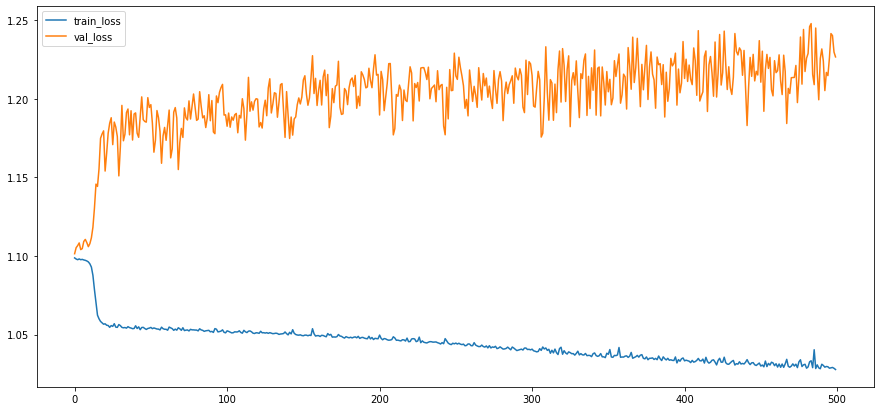

In [488]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,7))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["train_loss", "val_loss"])

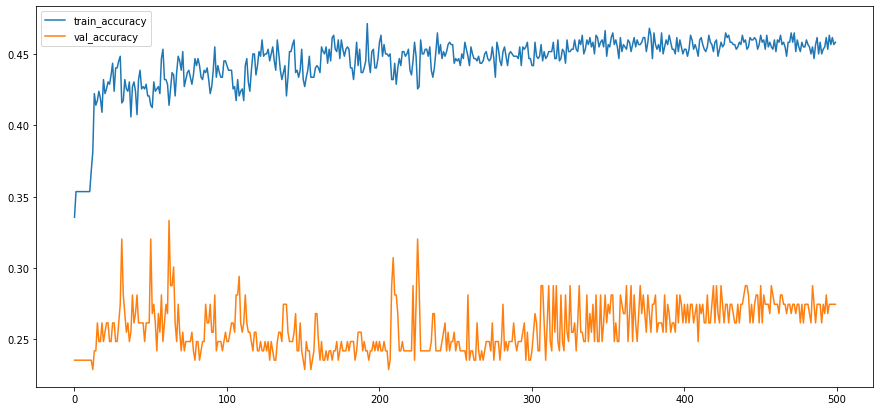

In [489]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,7))
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["train_accuracy", "val_accuracy"])

model.load_weights(filepath)
#**TEST PREDICTIONS**

In [490]:
model.load_weights(filepath)

model.predict(X_test)



array([[0.3227888 , 0.33460945, 0.34260175],
       [0.32278755, 0.334612  , 0.34260046],
       [0.32279155, 0.33458424, 0.34262422],
       [0.32279316, 0.33457637, 0.34263048],
       [0.32278493, 0.33463654, 0.3425785 ],
       [0.32279375, 0.33470657, 0.34249973],
       [0.3228256 , 0.33473146, 0.342443  ],
       [0.3228403 , 0.33472303, 0.34243667],
       [0.32284462, 0.33476138, 0.342394  ],
       [0.32283428, 0.33474723, 0.34241843],
       [0.32282934, 0.3347637 , 0.34240693],
       [0.32281843, 0.33469462, 0.34248695],
       [0.32281572, 0.33462116, 0.34256312],
       [0.32280904, 0.33455545, 0.34263554],
       [0.32279298, 0.3345686 , 0.3426384 ],
       [0.32278866, 0.3345782 , 0.34263316],
       [0.3227825 , 0.3345907 , 0.34262678],
       [0.3227856 , 0.33461162, 0.3426028 ],
       [0.32278827, 0.33465037, 0.3425613 ],
       [0.32279658, 0.334716  , 0.34248745],
       [0.3228151 , 0.33479023, 0.34239462],
       [0.3228234 , 0.33472332, 0.3424533 ],
       [0.

In [491]:
predict_trend = model.predict(X_test)
predict_trend = predict_trend.argmax(1)

predict_trend -= 1    # Position multiplier => class enconding minus 1

print(predict_trend)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


# **MEASURE MODEL PERFORMANCE**

Market profit: -63.69%


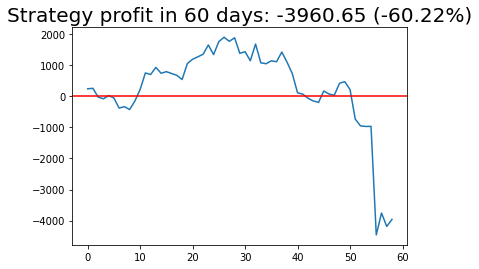

In [492]:
# TEST FOR PROFIT CONSIDERING LONG-SHORT STRATEGY

sample = pd.DataFrame([data.Close[-test_size:].tolist(), predict_trend])
sample = sample.T
sample.columns=['Actual','Position']
sample.Actual *= descale
sample['Profit'] = sample.Position * (sample.shift(-1).Actual - sample.Actual)

plt.title("Profit per day over history",fontsize=20)
sample['Wealth'] = sample['Profit'].cumsum()
sample.Wealth.plot()
plt.axhline(y=0, color='red')
plt.title("Strategy profit in {:.0f} days: {:.2f} ({:.2f}%)".format(
    len(sample.index),
    sample.loc[sample.index[-2], 'Wealth'],
    sample.loc[sample.index[-2], 'Wealth']/sample.loc[sample.index[0], 'Actual']*100),
    fontsize=20)

print("Market profit: {:.2f}%".format((sample.loc[sample.index[-2], 'Actual']/sample.loc[0, 'Actual']-1)*100))

In [493]:
sample

,Actual,Position,Profit,Wealth
0,6577.348816,1.0,244.015892,244.015892
1,6821.364707,1.0,16.371210,260.387101
2,6837.735917,1.0,-281.240918,-20.853817
3,6556.494999,1.0,-57.781627,-78.635444
4,6498.713371,1.0,104.919240,26.283796
5,6603.632612,1.0,-77.297975,-51.014179
6,6526.334636,1.0,-326.176121,-377.190301
7,6200.158515,1.0,46.269187,-330.921113
8,6246.427702,1.0,-92.239999,-423.161113
9,6154.187703,1.0,272.228103,-150.933009


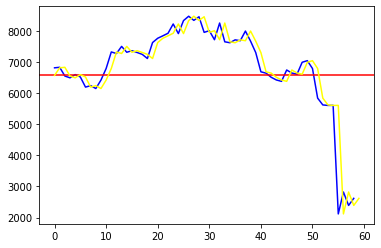

In [494]:
# Visualize Model vs Market (Buy&Hold) side by side

sample['TotalWealth'] = sample['Wealth'] + sample.Actual[0]
sample.TotalWealth.plot(color="blue")
plt.axhline(y=sample.Actual[0], color='red')
sample.Actual.plot(color='yellow')